# Import

In [2]:
import zipfile
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reading Data

In [3]:
zip_path = "/content/Teeth_Dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir("/content/"))

['.config', 'Teeth_Dataset.zip', 'Teeth_Dataset', 'sample_data']


# Exploring Data

In [4]:
data_dir = "/content/Teeth_Dataset"

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    print(f"\n{split.upper()} SET:")
    print(os.listdir(split_path))



TRAINING SET:
['MC', 'CaS', 'CoS', 'Gum', 'OC', 'OT', 'OLP']

VALIDATION SET:
['MC', 'CaS', 'CoS', 'Gum', 'OC', 'OT', 'OLP']

TESTING SET:
['MC', 'CaS', 'CoS', 'Gum', 'OC', 'OT', 'OLP']


In [5]:
def count_images(split_path):
    counts = {}
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    counts = count_images(split_path)
    print(f"\n{split.upper()} counts:")
    print(counts)



TRAINING counts:
{'MC': 540, 'CaS': 480, 'CoS': 450, 'Gum': 360, 'OC': 324, 'OT': 393, 'OLP': 540}

VALIDATION counts:
{'MC': 180, 'CaS': 160, 'CoS': 149, 'Gum': 120, 'OC': 108, 'OT': 131, 'OLP': 180}

TESTING counts:
{'MC': 180, 'CaS': 160, 'CoS': 149, 'Gum': 120, 'OC': 108, 'OT': 131, 'OLP': 180}


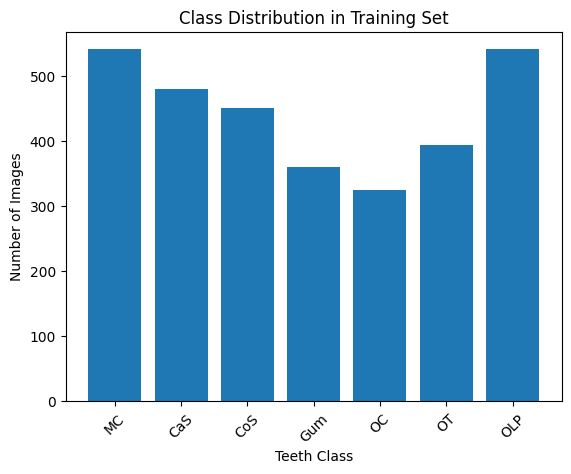

In [6]:
train_counts = count_images(os.path.join(data_dir, "Training"))

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Teeth Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


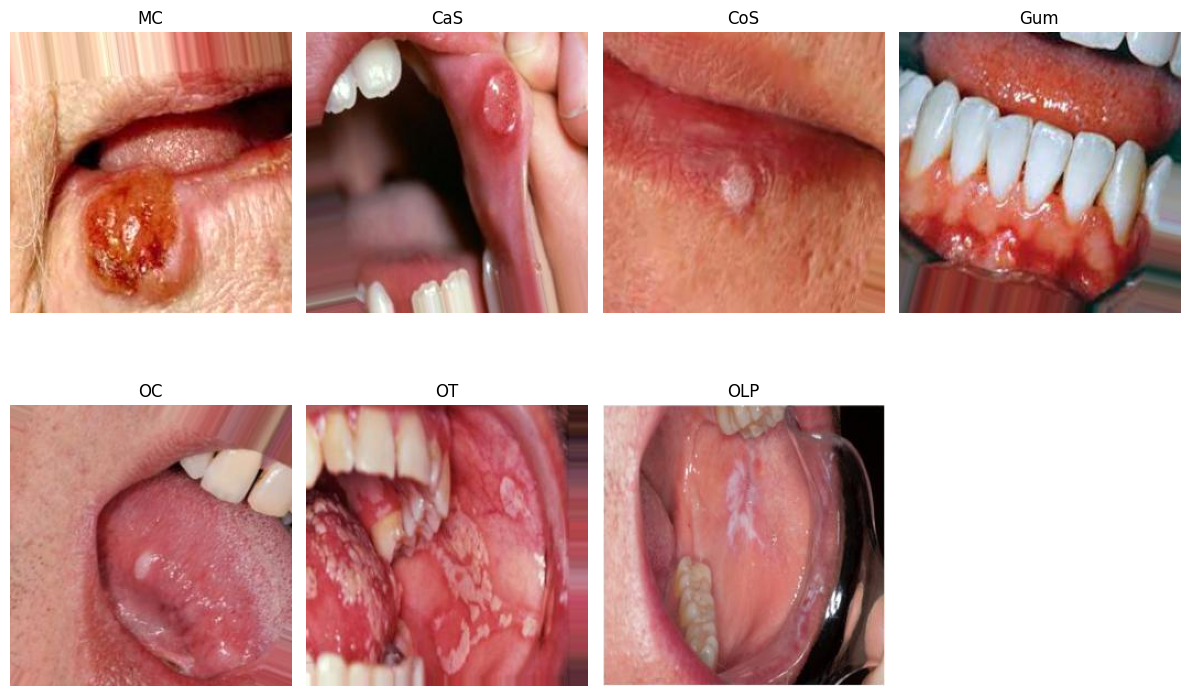

In [7]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_path = os.path.join(data_dir, "Training")

classes = os.listdir(train_path)

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:7]):  # limit to 7 classes
    cls_folder = os.path.join(train_path, cls)
    img_file = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
!pip install tensorflow

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False,
    classes=list(train_gen.class_indices.keys())
)


print("Detected mapping:", train_gen.class_indices)
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
print("idx_to_class:", idx_to_class)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Detected mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
idx_to_class: {0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}


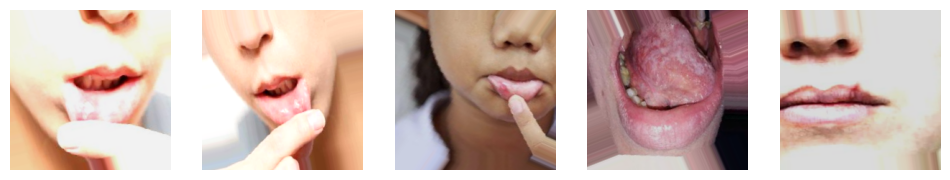

In [9]:
images, labels = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


# VGG 16 Model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers

wd = 1e-4  # weight decay (L2)

def conv_bn_relu(x, out_c, k=3, p="same"):
    x = layers.Conv2D(
        out_c, k, padding=p, use_bias=False,
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def VGG16(num_classes=7, block_dropout=0.15, head_dropout=0.3):
    inputs = layers.Input(shape=(224, 224, 3))

    # Block 1
    x = conv_bn_relu(inputs, 16)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 2
    x = conv_bn_relu(x, 32)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 3
    x = conv_bn_relu(x, 64)
    x = conv_bn_relu(x, 64)
    x = conv_bn_relu(x, 64)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)

    # Block 4
    x = conv_bn_relu(x, 128)
    x = conv_bn_relu(x, 128)
    x = conv_bn_relu(x, 128)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Dropout(block_dropout)(x)
    # Block 5
    x = conv_bn_relu(x, 128)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(block_dropout)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        512, activation="relu",
        kernel_initializer=initializers.HeNormal(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)
    x = layers.Dropout(head_dropout)(x)

    outputs = layers.Dense(
        num_classes, activation="softmax",
        kernel_initializer=initializers.GlorotUniform(),
        kernel_regularizer=regularizers.l2(wd)
    )(x)

    return models.Model(inputs, outputs, name="VGG16_Custom")

model = VGG16(num_classes=7)

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "VGG16_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 685,943 (2.62 MB)

 Trainable params: 684,439 (2.61 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [11]:
from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     restore_best_weights=True
# )

# fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.2463 - loss: 2.2890 - val_accuracy: 0.1449 - val_loss: 4.5265
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 436ms/step - accuracy: 0.3377 - loss: 1.9369 - val_accuracy: 0.1615 - val_loss: 6.2441
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.3912 - loss: 1.8139 - val_accuracy: 0.2140 - val_loss: 3.1721
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.4007 - loss: 1.7425 - val_accuracy: 0.2519 - val_loss: 2.7366
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 440ms/step - accuracy: 0.4587 - loss: 1.6077 - val_accuracy: 0.3949 - val_loss: 1.9426
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 445ms/step - accuracy: 0.4819 - loss: 1.5516 - val_accuracy: 0.4504 - val_loss: 1.7003
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.5242 - loss: 1.4623 - val_accuracy: 0.4027 - val_loss: 1.8511
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.5522 - loss: 1.4023 - val_accu

In [12]:
model.save("teeth_classificationfinal.h5")

In [13]:
model.save_weights("teeth_classifier_final.weights.h5")

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# same IMG_SIZE, BATCH_SIZE you used before
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    directory="/content/Teeth_Dataset/Testing",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse",                     # matches your compile (sparse CE)
    shuffle=False,                           # important for evaluation/CM
    classes=list(train_gen.class_indices.keys())  # enforce same class order
)

print("Test mapping:", test_gen.class_indices)


Found 1028 images belonging to 7 classes.
Test mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [15]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test: loss={test_loss:.4f}  acc={test_acc:.4f}")


Test: loss=0.5852  acc=0.8920


In [16]:
import matplotlib.pyplot as plt

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):
    epochs_range = range(1, len(epochs)+1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'g-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'g-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


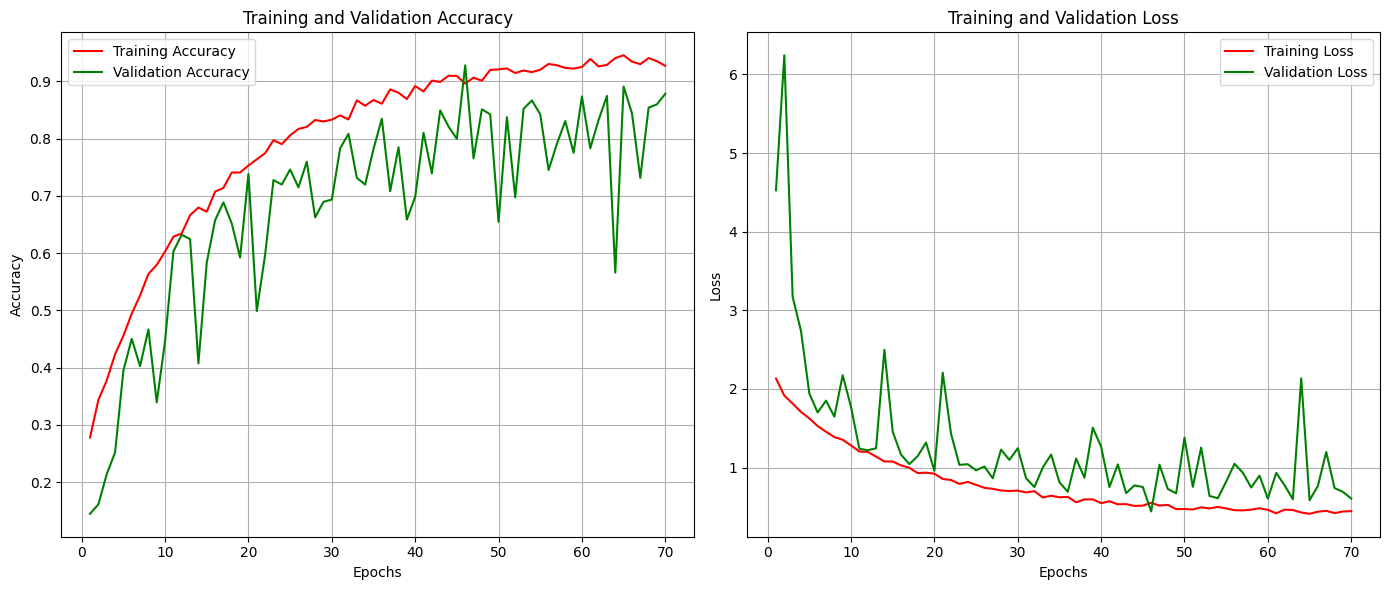

In [17]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']
epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(model, test_generator, class_names):
    y_true = test_generator.classes

    y_pred_probs = model.predict(test_generator)

    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


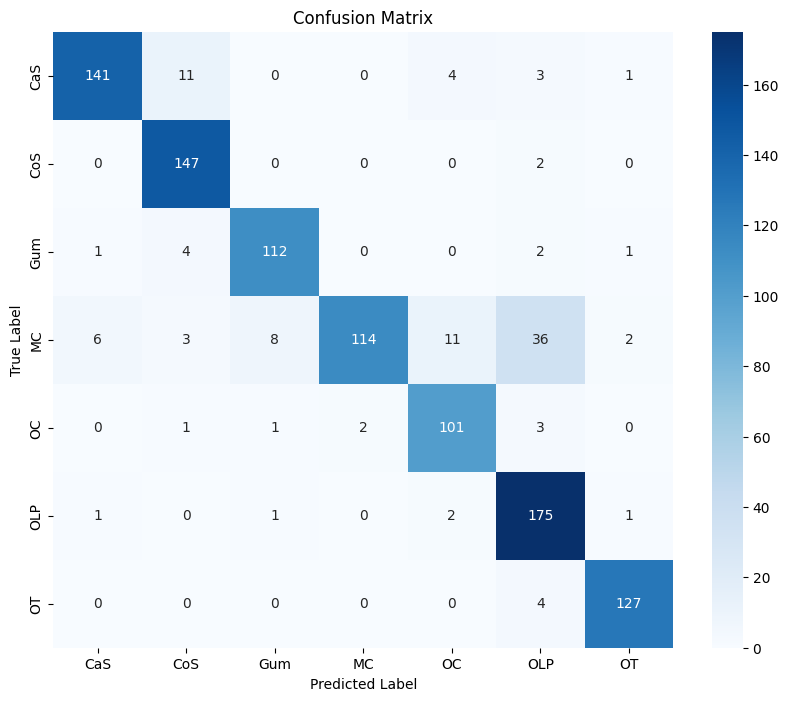

In [20]:
class_names = list(test_gen.class_indices.keys())

plot_conf_matrix(model, test_gen, class_names)